In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time
import unicodedata


In [5]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [3]:
# path = os.path.abspath('.')+'/spa-eng/spa.txt'

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
path = os.path.abspath('.')+'/drive/My Drive/spa.txt'

In [9]:
en, sp, _= create_dataset(path, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [10]:
len(en)

124325

In [11]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang, _ = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
num_examples = 30000
input_tensor, target_tensor, inp_lang_tok, targ_lang_tok = load_dataset(path, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


24000 24000 6000 6000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang_tok, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang_tok, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
35 ----> tengo
11 ----> que
459 ----> volver
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
59 ----> ve
77 ----> got
15 ----> to
35 ----> go
90 ----> back
3 ----> .
2 ----> <end>


In [17]:
target_tensor.shape

(30000, 11)

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tok.word_index) + 1
vocab_tar_size = len(targ_lang_tok.word_index)+ 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
print(next(iter(dataset)))

(<tf.Tensor: shape=(64, 16), dtype=int32, numpy=
array([[   1,   36,   38, ...,    0,    0,    0],
       [   1,   30,    7, ...,    0,    0,    0],
       [   1,   58, 2384, ...,    0,    0,    0],
       ...,
       [   1,   32, 3288, ...,    0,    0,    0],
       [   1,   25,   47, ...,    0,    0,    0],
       [   1,   27,    7, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64, 11), dtype=int32, numpy=
array([[   1,    4,   66,   49,  775,    3,    2,    0,    0,    0,    0],
       [   1,   20,    8,   49,  583,    3,    2,    0,    0,    0,    0],
       [   1,   28,  125,  224,    3,    2,    0,    0,    0,    0,    0],
       [   1,    7,    8,   10, 3598,    3,    2,    0,    0,    0,    0],
       [   1,   14,   11,  630,    3,    2,    0,    0,    0,    0,    0],
       [   1,   53,  206,   42,    3,    2,    0,    0,    0,    0,    0],
       [   1,  197,   11,   33,  595,    3,    2,    0,    0,    0,    0],
       [   1,   17,   91,  557,    3,    2,    0, 

In [20]:
x = tf.data.Dataset.from_tensor_slices(([1, 2, 3,4],[5,6,7,8])).shuffle(6)
list(x.as_numpy_iterator())
x = x.batch(3)
list(x.as_numpy_iterator())
# dataset = dataset.enumerate(start=5)
# for element in dataset.as_numpy_iterator():
#   print(element)


[(array([1, 3, 2], dtype=int32), array([5, 7, 6], dtype=int32)),
 (array([4], dtype=int32), array([8], dtype=int32))]

In [21]:
# print(next(iter(dataset)))

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
        return_sequences=True,
        return_state=True,
        recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()

In [24]:
sample_hidden.shape

TensorShape([64, 1024])

In [25]:
example_input_batch, example_target_batch = next(iter(dataset))
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [26]:
print('Encoder output shape: batch size, sequence length, units {}'.format(sample_output.shape))

Encoder output shape: batch size, sequence length, units (64, 16, 1024)


In [27]:
print('Encoder Hidden state: batch_size, units {}'.format(sample_hidden.shape))

Encoder Hidden state: batch_size, units (64, 1024)


In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query,1)

    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch_size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_lengths) {}".format(attention_weights.shape))

Attention result shape: (batch_size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_lengths) (64, 16, 1)


In [30]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer = 'glorot_uniform')
    
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector,1), x], axis=-1)
    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print('decoder output shape: (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))


decoder output shape: (batch_size, vocab_size) (64, 4817)


In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [33]:
checkpoint_dir = os.path.abspath('.')+"/drive/My Drive/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [34]:
targ_lang_tok.word_index['<start>']

1

In [35]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss=0

  with tf.GradientTape() as tape:

    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tok.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss/ int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss



In [36]:
for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
  print(batch)
  print(inp)
  print(targ)
  break

0
tf.Tensor(
[[   1    5   89 ...    0    0    0]
 [   1   23  133 ...    0    0    0]
 [   1 2181   14 ...    0    0    0]
 ...
 [   1    5   29 ...    0    0    0]
 [   1    8   12 ...    0    0    0]
 [   1   14  372 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1    8  446   55    6    2    0    0    0    0    0]
 [   1    4   66  459   61  121    3    2    0    0    0]
 [   1  107  653    3    2    0    0    0    0    0    0]
 [   1   27   12   88   90    3    2    0    0    0    0]
 [   1   87 1634   18   37    2    0    0    0    0    0]
 [   1   17   72    9   39    3    2    0    0    0    0]
 [   1   54  598    5    6    2    0    0    0    0    0]
 [   1    4  325    7   15   52    3    2    0    0    0]
 [   1   20   93   12   56 1753    3    2    0    0    0]
 [   1  372    8   30  397    6    2    0    0    0    0]
 [   1   32   11   13 2754    6    2    0    0    0    0]
 [   1    8   19  388    6    2    0    0    0    0    0]
 [   1   13   84    8 

In [46]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))

  if (epoch + 1) % 2 ==0:
    checkpoint.save(file_prefix= checkpoint_prefix)
  
  print('Epoch {}, Loss {}'.format(epoch+1, total_loss/steps_per_epoch))

  print('Time taken for 1 epoch {} sec \n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4089
Epoch 1 Batch 100 Loss 2.1233
Epoch 1 Batch 200 Loss 1.8076
Epoch 1 Batch 300 Loss 1.6243
Epoch 1, Loss 2.010434150695801
Time taken for 1 epoch 43.3237361907959 sec 

Epoch 2 Batch 0 Loss 1.5292
Epoch 2 Batch 100 Loss 1.4762
Epoch 2 Batch 200 Loss 1.3745
Epoch 2 Batch 300 Loss 1.2801
Epoch 2, Loss 1.350333571434021
Time taken for 1 epoch 32.97252702713013 sec 

Epoch 3 Batch 0 Loss 1.0744
Epoch 3 Batch 100 Loss 0.9748
Epoch 3 Batch 200 Loss 0.8279
Epoch 3 Batch 300 Loss 0.8952
Epoch 3, Loss 0.9298057556152344
Time taken for 1 epoch 32.10030651092529 sec 

Epoch 4 Batch 0 Loss 0.6432
Epoch 4 Batch 100 Loss 0.6000
Epoch 4 Batch 200 Loss 0.5846
Epoch 4 Batch 300 Loss 0.6167
Epoch 4, Loss 0.6250849962234497
Time taken for 1 epoch 33.39562177658081 sec 

Epoch 5 Batch 0 Loss 0.4089
Epoch 5 Batch 100 Loss 0.4123
Epoch 5 Batch 200 Loss 0.3813
Epoch 5 Batch 300 Loss 0.3902
Epoch 5, Loss 0.4226386845111847
Time taken for 1 epoch 31.902763605117798 sec 

Epoch 6 Batc

In [37]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang_tok.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')

  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang_tok.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang_tok.index_word[predicted_id] + ' '

    if targ_lang_tok.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [38]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [39]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translations: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(" "), result.split(' '))

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translations: it s very cold here . <end> 


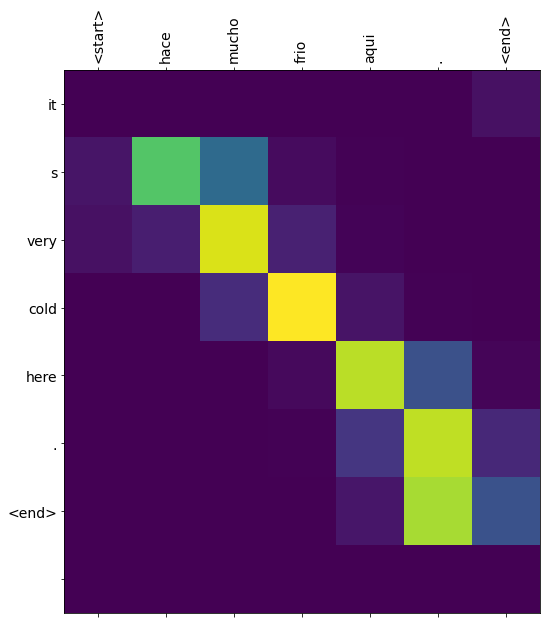

In [43]:
translate(u'hace mucho frio aqui.')